Version Notes:

Base assets don't improve predictability??? (ie. can't match R-squareds and test-stats/pvalues)

Bootstrap correct??? (does author even do time-series bootstrap?)

# Creation of GDP and CPI Mimicking portfolios
Note: could use unexpected inflation from Chen, Roll and Ross, projected onto asset returns as a robustness test

## Data Prep

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [208]:
def get_data(date):
    '''
    Imports and cleans data at the monthly or quarterly frequency.
    '''
    if date == 'monthly': data = pd.read_csv('merged_data.csv', index_col=0)
    else: data = pd.read_csv('merged_data_q.csv', index_col=0)
    
    data['def'] = np.log(data['corp_bond_return']/data['corp_bond_return'].shift(1)) - data['20y_return']
    data['term'] = data['30y_return'] - data['rf']
    
    data['defy'] = (data['BAA'] - data['AAA'])/100
    data['termy'] = (data['10 year'] - data['1 year'])/100
    
    # Predictors
    predictors = data[['SL', 'SM', 'SH', 'BL', 'HM', 'BH',
                                   'def', 'term', 'defy', 'termy', 'rf']].copy().dropna()
    portfolios = ['SL', 'SM', 'SH', 'BL', 'HM', 'BH']
    
    for portfolio in portfolios:
        predictors[portfolio] = predictors[portfolio]/100 - predictors['rf'] 
    
    if date == 'monthly':
        # GDP & CPI
        gdp = data['BBKMGDP'].rename('gdp').to_frame().iloc[:-3]
        cpi = data['CPIAUCSL'].rename('cpi').to_frame().iloc[:-3]

        # Transformations 
        gdp['gdp_mom'] = (1 + gdp['gdp'] / 100)**(1/12) - 1 # de-annualize
        gdp['level'] = (1+gdp['gdp_mom']).cumprod()
        gdp['gdp_yoy'] = np.log(gdp['level'] / gdp['level'].shift(12)) # 4 quarter change = 12 month change

        cpi['cpi_mom'] = np.log(cpi['cpi'] / cpi['cpi'].shift(1))
        cpi['cpi_yoy'] = np.log(cpi['cpi'] / cpi['cpi'].shift(12))
        cpi = cpi.shift(1)
    
    else:
        # GDP & CPI
        gdp = data['GDPC1'].rename('gdp').to_frame().iloc[:-3]
        cpi = data['CPIAUCSL'].rename('cpi').to_frame().iloc[:-3]

        # Transformations 
        gdp['gdp_qoq'] = np.log(gdp['gdp'] / gdp['gdp'].shift(1))
        gdp['gdp_4qoq'] = np.log(gdp['gdp'] / gdp['gdp'].shift(4))

        cpi['cpi_qoq'] = np.log(cpi['cpi'] / cpi['cpi'].shift(1))
        cpi['cpi_4qoq'] = np.log(cpi['cpi'] / cpi['cpi'].shift(4))
        cpi = cpi.shift(1)

    return predictors, gdp, cpi

In [209]:
predictors_q, gdp_q, cpi_q = get_data('quarterly')

In [210]:
predictors, gdp, cpi = get_data('monthly')

## Can the base assets predict future GDP & CPI?
Since this is an expectation of monthly GDP, instead of "news related to future GDP growth", this factor would be more related to innovations in expectations of future GDP growth. 

In [211]:
def pred(y, X, test):
    '''
    Function to run prediction and return the Wald Statistics based on coefficient restrictions ('test').
    '''
    
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    wald = model.wald_test(','.join(test), scalar=True, use_f=False)
    
    return [f'{wald.statistic:0.2f}', f'{wald.pvalue:0.5f}']

In [212]:
def monthly_prediction():
    '''
    Function to run several prediction models at the monthly frequency.
    '''
    
    # Predictor Data
    controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
    constant = controls.iloc[:,0]
    assets = predictors.iloc[1:,0:8].shift(1).dropna()
    
    # Outcome Variables
    gdp_mom = gdp['gdp_mom'].loc['1973-04':].iloc[2:]
    gdp_yoy = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]
    
    cpi_mom = cpi['cpi_mom'].loc['1973-04':].iloc[2:]
    cpi_yoy = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]
    
    
    wald_stats = {}
    wald_stats['Legend'] = ['Wald Statistic', 'p-value']
    # Control Models
    coeffs_0 = [x + '=0' for x in controls.iloc[:,1:]]

    wald_stats['gdp_mom_control'] = pred(gdp_mom,controls,coeffs_0)   
    wald_stats['cpi_mom_control'] = pred(cpi_mom,controls,coeffs_0)

    wald_stats['gdp_yoy_control'] = pred(gdp_yoy,controls,coeffs_0)   
    wald_stats['cpi_yoy_control'] = pred(cpi_yoy,controls,coeffs_0)
    
    # Only Base Assets
    coeffs_1 = [x + '=0' for x in assets]

    wald_stats['gdp_mom_assets'] = pred(gdp_mom,assets,coeffs_1)
    wald_stats['cpi_mom_assets'] = pred(cpi_mom,assets,coeffs_1)

    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)
    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)

    # Base Assets + Controls    
    wald_stats['gdp_mom_assets_controls'] = pred(gdp_mom,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_mom_assets_controls'] = pred(cpi_mom,pd.concat([controls, assets], axis=1),coeffs_1)
                                                 
    wald_stats['gdp_yoy_assets_controls'] = pred(gdp_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_yoy_assets_controls'] = pred(cpi_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    
    return pd.DataFrame(wald_stats).set_index('Legend').T

In [213]:
def quarterly_prediction():
    '''
    Function to run several prediction models at the quarterly frequency.
    '''
    
    # Predictor Data
    controls = sm.add_constant(predictors_q.iloc[:-2,-3:].shift(2).dropna())
    constant = controls.iloc[:-2,0]
    assets = predictors_q.iloc[1:-2,0:8].shift(1).dropna()
    
    # Outcome Variables
    gdp_qoq = gdp_q['gdp_qoq'].loc['1973-09':]
    gdp_yoy = gdp_q['gdp_4qoq'].loc['1973-09':]
    
    cpi_qoq = cpi_q['cpi_qoq'].loc['1973-09':]
    cpi_yoy = cpi_q['cpi_4qoq'].loc['1973-09':]
    
    
    wald_stats = {}
    wald_stats['Legend'] = ['Wald Statistic', 'p-value']
    # Control Models
    coeffs_0 = [x + '=0' for x in controls.iloc[:,1:]]

    wald_stats['gdp_qoq_control'] = pred(gdp_qoq,controls,coeffs_0)   
    wald_stats['cpi_qoq_control'] = pred(cpi_qoq,controls,coeffs_0)

    wald_stats['gdp_yoy_control'] = pred(gdp_yoy,controls,coeffs_0)   
    wald_stats['cpi_yoy_control'] = pred(cpi_yoy,controls,coeffs_0)
    
    # Only Base Assets
    coeffs_1 = [x + '=0' for x in assets]

    wald_stats['gdp_qoq_assets'] = pred(gdp_qoq,assets,coeffs_1)
    wald_stats['cpi_qoq_assets'] = pred(cpi_qoq,assets,coeffs_1)

    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)
    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)

    # Base Assets + Controls    
    wald_stats['gdp_qoq_assets_controls'] = pred(gdp_qoq,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_qoq_assets_controls'] = pred(cpi_qoq,pd.concat([controls, assets], axis=1),coeffs_1)
                                                 
    wald_stats['gdp_yoy_assets_controls'] = pred(gdp_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_yoy_assets_controls'] = pred(cpi_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    
    return pd.DataFrame(wald_stats).set_index('Legend').T

In [214]:
monthly_prediction()

Legend,Wald Statistic,p-value
gdp_mom_control,10.99,0.01179
cpi_mom_control,33.50,0.00000
gdp_yoy_control,37.74,0.00000
cpi_yoy_control,54.70,0.00000
gdp_mom_assets,19.76,0.01130
cpi_mom_assets,25.43,0.00131
gdp_yoy_assets,30.93,0.00014
gdp_mom_assets_controls,8.71,0.36692
cpi_mom_assets_controls,43.09,0.00000
gdp_yoy_assets_controls,10.31,0.24425


The null is that the beta on the base assets are jointly 0 (except for only 'control' which is that the beta on the controls are 0).

Thus we reject the null that the assets don't increase predictability in all cases except for MoM GDP w/ assets + controls and YoY GDP w/ assets + controls.

In [215]:
quarterly_prediction()

Legend,Wald Statistic,p-value
gdp_qoq_control,14.95,0.00186
cpi_qoq_control,24.27,0.00002
gdp_yoy_control,28.41,0.00000
cpi_yoy_control,39.56,0.00000
gdp_qoq_assets,108.34,0.00000
cpi_qoq_assets,42.71,0.00000
gdp_yoy_assets,64.04,0.00000
gdp_qoq_assets_controls,24.77,0.00170
cpi_qoq_assets_controls,46.72,0.00000
gdp_yoy_assets_controls,12.57,0.12759


Overall the results are similar to the monthly case. The asset betas are insignificant for YoY GDP with controls. 

Vasslou (2003) finds a Wald Statistic of 18.88 over the sample from 1953-1998, using CAY as a control and a different version of DEF, while I obtain 12.57. Further her bootstrapped p-value was 0.0973, and my asymptotic p-value is 0.12579. Hence it is likely that either since 1998, the ability for the base assets to predict GDP has decreased, or just statistically since the p-values are near 10%, any significance was minor to begin with. 

Regardless we can proceed with creating the factor mimicking portfolios. 

### GDP Bootstrap

Vassalou (2003) use a bootstrap procedure to see if the base assets are jointly significant in predicted GDP above and beyond the control variables.

Specifically the bootstrap procedure is as follows:

1) The regression is estimated: 

<font size=3>
$
\%\Delta GDP_{t,t+12} = a + cB_{t-1,t} + kZ_{t-2,t-1} + e_{t,t+12}
$
</font>

Where B is a vector of returns on the 8 base assets, and Z is a vector of control variables. The Wald Statistic and p-value is stored.

2) Draw a random sample (with replacement) of the explanatory variables and estimated residuals

3) Compute a GDP growth rate forcast assuming c=0

<font size=3>
$
\%\Delta \hat{GDP}_{t,t+12} = \hat{a} + \hat{k}Z_{t-2,t-1} + \hat{e}_{t,t+12}
$
</font>

4) Regress the null GDP growth rate from (3) on the bootstrapped sample of explanatory variables; compute the Wald Statistic

6) This is repeated 10,000 times. The actual Wald Statistic is compared against the bootstrapped distribution, and the emprical p-value is computed. 

In [ ]:
# Data
controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
constant = controls.iloc[:,0]
assets = predictors.iloc[1:,0:8].shift(1).dropna()
y = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]

#### Only base assets

In [11]:
# Initial Model
model1 = sm.OLS(y, pd.concat([constant, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':12})

coeffs1_0 = [x + '=0' for x in assets]
wald_stat1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).statistic
p1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p1:0.5f}', 'Wald Stat= ', f'{wald_stat1:0.3f}')

P-value= 0.51426 Wald Stat=  7.209


In [12]:
# model1.summary()

In [13]:
sample_df1 = pd.concat([y, constant, assets], axis=1)
n = len(sample_df1)

In [14]:
# Bootstrap
boot1_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df1.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot1_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot1_wald = np.array(boot1_wald)

In [15]:
empirical_p1 = np.sum(boot1_wald <= wald_stat1)/len(boot1_wald)
print(f'{empirical_p1: 0.5f}')

 0.07540


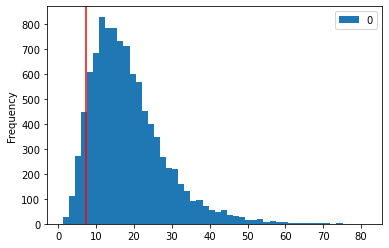

In [38]:
pd.DataFrame(boot1_wald).plot.hist(bins=50).axvline(wald_stat1, color='red')

#### Base assets + Controls

In [39]:
# Initial Model
model2 = sm.OLS(y, pd.concat([controls, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':12})

coeffs2_0 = [x + '=0' for x in assets]
wald_stat2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).statistic
p2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p2:0.5f}', 'Wald Stat= ', f'{wald_stat2:0.3f}')

P-value= 0.22029 Wald Stat=  10.683


In [18]:
# model2.summary()

In [19]:
sample_df2 = pd.concat([y, controls, assets], axis=1)
n = len(sample_df2)

In [20]:
# Bootstrap
boot2_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df2.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot2_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot2_wald = np.array(boot2_wald)

In [21]:
empirical_p2 = np.sum(boot2_wald <= wald_stat2)/len(boot2_wald)
print(f'{empirical_p2: 0.5f}')

 0.10150


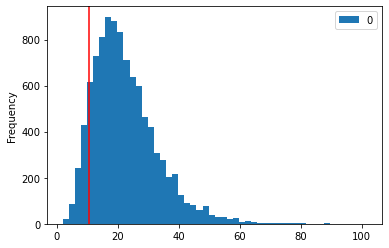

In [40]:
pd.DataFrame(boot2_wald).plot.hist(bins=50).axvline(wald_stat2, color='red')

### CPI Bootstrap

In [168]:
y_cpi = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]

In [24]:
sample_df_cpi = pd.concat([y_cpi, controls, assets], axis=1)
n = len(sample_df_cpi)

In [25]:
boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df_cpi.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot_cpi_wald = np.array(boot_cpi_wald)

In [26]:
empirical_p_cpi = np.sum(boot_cpi_wald <= wald_stat_cpi)/len(boot_cpi_wald)
print(f'{empirical_p_cpi: 0.5f}')

 0.08030


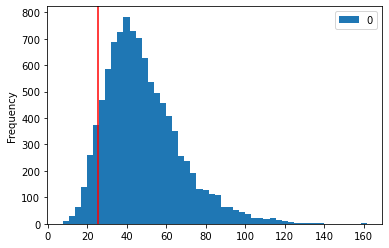

In [41]:
pd.DataFrame(boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

#### Non-Moving Block Bootstrap
1) Partition the sample into b blocks of length l (retains time series order)
2) Randomly sample (with replacement) blocks of the data
3) Perform the operation of the bootstrap

In [122]:
import random

In [123]:
index = np.linspace(0,len(assets),10,0).round().astype('int')

boot_sample = []
for i in range(len(index)-1):
    boot_sample.append(sample_df_cpi.iloc[index[i]:index[i+1]])

In [125]:
# CPI Block Bootstrap
block_boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = pd.concat([random.choice(boot_sample) for i in range(10)]).sort_index()
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    block_boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

block_boot_cpi_wald = np.array(block_boot_cpi_wald)

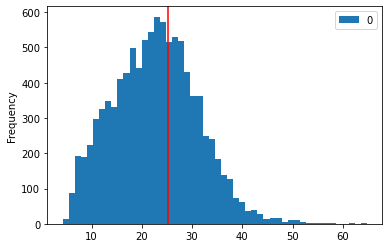

In [126]:
pd.DataFrame(block_boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

In [127]:
empirical_p_cpi_block = np.mean(block_boot_cpi_wald <= wald_stat_cpi)
print(f'{empirical_p_cpi_block: 0.5f}')

 0.61960


#### Moving Block Bootstrap
1) Decide on block of length l, and then create b blocks of length l, where the data overlaps
2) Randomly sample (with replacement) blocks of the data
3) Perform the operation of the bootstrap

In [153]:
index = range(len(assets))

boot_sample = []
for i in range(len(index)-100):
    boot_sample.append(sample_df_cpi.iloc[index[i]:index[i+100]])

In [154]:
# CPI Moving Block Bootstrap
block_boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = pd.concat([random.choice(boot_sample) for i in range(6)]).sort_index()
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    block_boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

block_boot_cpi_wald = np.array(block_boot_cpi_wald)

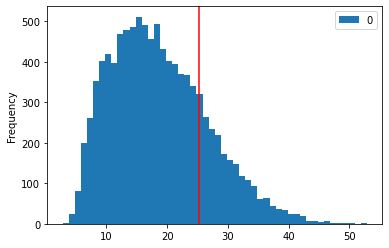

In [155]:
pd.DataFrame(block_boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

In [156]:
empirical_p_cpi_block = np.mean(block_boot_cpi_wald <= wald_stat_cpi)
print(f'{empirical_p_cpi_block: 0.5f}')

 0.79510


## Factor Creation

Since they the regressors are identical in both cases, we can use Multivariate OLS/Seemingly Unrelated Regression, to account for any cross-equation correlation between the error terms. In essence we are mapping the returns of the base assets onto true GDP and CPI values so the output are asset returns.

The factors are constructed as follows.

We must demean the macro variables and form the factor by projecting just the asset returns onto the macro variable.

First the regression is estimated:

<font size=3>
$
\%\Delta GDP_{t,t+k} = a + cB_{t-1,t} + kZ_{t-2,t-1} + e_{t,t+12}
$
</font>


Where $Z$ is a vector of controls, and $B$ are the zero-investment base assets.

Then the macro factor expressed in terms of asset returns is:

<font size=3>
$
GDP_{t-1,t} = \hat{c} B_{t-1,t}
$
</font>

### GDP and CPI Correlations
At every frequency GDP and CPI are relatively uncorrelated so there is no need to orthogonalize them.

In [216]:
macro_m = pd.merge(gdp[['gdp_mom', 'gdp_yoy']], cpi[['cpi_mom', 'cpi_yoy']], left_index=True, right_index=True)
macro_q = pd.merge(gdp_q[['gdp_qoq', 'gdp_4qoq']], cpi_q[['cpi_qoq', 'cpi_4qoq']], left_index=True, right_index=True)

In [227]:
macro_m[['gdp_yoy', 'cpi_yoy']].corr()

pd.concat([macro_m[['gdp_yoy', 'cpi_yoy']].corr(), 
           macro_m[['gdp_mom', 'cpi_mom']].corr(),
           macro_q[['gdp_qoq', 'cpi_qoq']].corr(),
           macro_q[['gdp_4qoq', 'cpi_4qoq']].corr()])

,gdp_yoy,cpi_yoy,gdp_mom,cpi_mom,gdp_qoq,cpi_qoq,gdp_4qoq,cpi_4qoq
gdp_yoy,1.00000,-0.07249,NaN,NaN,NaN,NaN,NaN,NaN
cpi_yoy,-0.07249,1.00000,NaN,NaN,NaN,NaN,NaN,NaN
gdp_mom,NaN,NaN,1.000000,0.046926,NaN,NaN,NaN,NaN
cpi_mom,NaN,NaN,0.046926,1.000000,NaN,NaN,NaN,NaN
gdp_qoq,NaN,NaN,NaN,NaN,1.000000,-0.107612,NaN,NaN
cpi_qoq,NaN,NaN,NaN,NaN,-0.107612,1.000000,NaN,NaN
gdp_4qoq,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,-0.16212
cpi_4qoq,NaN,NaN,NaN,NaN,NaN,NaN,-0.16212,1.00000


### Systems Estimation

In [238]:
from linearmodels.system.model import SUR

In [241]:
# Monthly Data
controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
constant = controls.iloc[:,0]
assets = predictors.iloc[1:,0:8].shift(1).dropna()

gdp_mom = gdp['gdp_mom'].loc['1973-04':].iloc[2:]
gdp_yoy = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]

cpi_mom = cpi['cpi_mom'].loc['1973-04':].iloc[2:]
cpi_yoy = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]


# Quarterly Data
controls_q = sm.add_constant(predictors_q.iloc[:-2,-3:].shift(2).dropna())
constant_q = controls_q.iloc[:-2,0]
assets_q = predictors_q.iloc[1:-2,0:8].shift(1).dropna()

gdp_qoq = gdp_q['gdp_qoq'].loc['1973-09':]
gdp_4qoq = gdp_q['gdp_4qoq'].loc['1973-09':]

cpi_qoq = cpi_q['cpi_qoq'].loc['1973-09':]
cpi_4qoq = cpi_q['cpi_4qoq'].loc['1973-09':]

In [245]:
# GDP and CPI Stacked
y_mom = pd.merge(gdp_mom, cpi_mom, left_index=True, right_index=True)
y_yoy = pd.merge(gdp_yoy, cpi_yoy, left_index=True, right_index=True)

y = pd.merge(y_mom, y_yoy, left_index=True, right_index=True)
X = sm.add_constant(pd.concat([controls, assets], axis=1))


y_qoq = pd.merge(gdp_qoq, cpi_qoq, left_index=True, right_index=True)
y_4qoq = pd.merge(gdp_4qoq, cpi_4qoq, left_index=True, right_index=True)

y_q = pd.merge(y_qoq, y_4qoq, left_index=True, right_index=True)
X_q = sm.add_constant(pd.concat([controls_q, assets_q], axis=1))

In [246]:
# Factor Models
monthly_model = SUR.multivariate_ls(y, X).fit(cov_type='kernel', kernel='bartlett')

quarterly_model = SUR.multivariate_ls(y_q, X_q).fit(cov_type='kernel', kernel='bartlett')

In [247]:
print(monthly_model)

                           System OLS Estimation Summary                           
Estimator:                        OLS   Overall R-squared:                   0.3964
No. Equations.:                     4   McElroy's R-squared:                 0.3073
No. Observations:                 595   Judge's (OLS) R-squared:             0.3964
Date:                Sat, Mar 18 2023   Berndt's R-squared:                  0.7395
Time:                        16:04:47   Dhrymes's R-squared:                 0.3964
                                        Cov. Estimator:                      kernel
                                        Num. Constraints:                      None
                Equation: gdp_mom, Dependent Variable: gdp_mom                
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0015     0.0010     1.5081     0.1315     -0.0004      0.0034
defy        

In [323]:
monthly_coeffs = pd.DataFrame(monthly_model.params).reset_index()
monthly_coeffs = monthly_coeffs[~(monthly_coeffs['index'].str.contains('const|defy|termy|rf'))]

quarterly_coeffs = pd.DataFrame(quarterly_model.params).reset_index()
quarterly_coeffs = quarterly_coeffs[~(quarterly_coeffs['index'].str.contains('const|defy|termy|rf'))]

In [324]:
gdp_mom_coeffs, cpi_mom_coeffs, gdp_yoy_coeffs, cpi_yoy_coeffs = [monthly_coeffs[monthly_coeffs['index'].str.contains(var)]['params'] 
                                                                  for var in ['gdp_mom', 'cpi_mom', 'gdp_yoy', 'cpi_yoy']]

gdp_qoq_coeffs, cpi_qoq_coeffs, gdp_4qoq_coeffs, cpi_4qoq_coeffs = [quarterly_coeffs[quarterly_coeffs['index'].str.contains(var)]['params'] 
                                                                    for var in ['gdp_qoq', 'cpi_qoq', 'gdp_4qoq', 'cpi_4qoq']]


monthly_factors = pd.DataFrame({var:coeffs @ assets.values.T for var, coeffs in 
                                zip(['gdp_mom', 'cpi_mom', 'gdp_yoy', 'cpi_yoy'], [gdp_mom_coeffs, cpi_mom_coeffs, gdp_yoy_coeffs, cpi_yoy_coeffs])}, index=assets.index)

quarterly_factors = pd.DataFrame({var:coeffs @ assets_q.values.T for var, coeffs in 
                                  zip(['gdp_qoq', 'cpi_qoq', 'gdp_4qoq', 'cpi_4qoq'], [gdp_qoq_coeffs, cpi_qoq_coeffs, gdp_4qoq_coeffs, cpi_4qoq_coeffs])}, index=assets_q.index)

### Factor Summary Statistics

In [325]:
monthly_factors.describe()

,gdp_mom,cpi_mom,gdp_yoy,cpi_yoy
count,595.000000,595.000000,595.000000,595.000000
mean,0.000156,-0.000105,0.000410,-0.000483
std,0.002537,0.000828,0.004944,0.004336
min,-0.023668,-0.003632,-0.026492,-0.015349
25%,-0.000774,-0.000575,-0.002418,-0.002939
50%,0.000285,-0.000085,0.000450,-0.000581
75%,0.001248,0.000413,0.003171,0.001920
max,0.011266,0.002469,0.017364,0.019616


In [292]:
# Annualized average returns
((1+monthly_factors.describe().loc['mean'])**12)-1

gdp_mom    0.001876
cpi_mom   -0.001255
gdp_yoy    0.004928
cpi_yoy   -0.005782
Name: mean, dtype: float64

In [293]:
quarterly_factors.describe()

,gdp_qoq,cpi_qoq,gdp_4qoq,cpi_4qoq
count,196.000000,196.000000,196.000000,196.000000
mean,0.000643,-0.001143,0.001605,-0.002433
std,0.006135,0.003161,0.008166,0.007178
min,-0.034030,-0.011667,-0.044525,-0.024606
25%,-0.001832,-0.002708,-0.002011,-0.006698
50%,0.000667,-0.001035,0.001869,-0.002742
75%,0.002780,0.000728,0.005577,0.001846
max,0.029051,0.007712,0.026502,0.018293


In [297]:
# Annualized average returns
((1+quarterly_factors.describe().loc['mean'])**4)-1

gdp_qoq     0.002573
cpi_qoq    -0.004566
gdp_4qoq    0.006435
cpi_4qoq   -0.009697
Name: mean, dtype: float64

In [301]:
# monthly_factors.to_csv('monthly_factors.csv')
# quarterly_factors.to_csv('quarterly_factors.csv')

### Factor Plots

In [339]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [314]:
# Plots of factors vs actual values
# pd.DataFrame({'True GDP':gdp_yoy, 'GDP Factor':gdp_yoy_factor, 'Fitted GDP':monthly_model.predict()['gdp_yoy'].iloc[:,0]}).iloc[:-36].plot(figsize=(16,8))

In [315]:
# pd.DataFrame({'True CPI':y_cpi, 'GDP Factor':cpi_factor, 'Fitted GDP':model.predict()['cpi_yoy'].iloc[:,0]}).plot()

In [335]:
# Plot Data
monthly_true = pd.concat([gdp_mom, cpi_mom, gdp_yoy, cpi_yoy], axis=1).add_prefix('true_')
monthly_fitted = pd.concat([monthly_model.predict()['gdp_mom'].iloc[:,0], 
                            monthly_model.predict()['cpi_mom'].iloc[:,0], 
                            monthly_model.predict()['gdp_yoy'].iloc[:,0], 
                            monthly_model.predict()['cpi_yoy'].iloc[:,0]], axis=1).add_prefix('fitted_')

quarterly_true = pd.concat([gdp_qoq, cpi_qoq, gdp_4qoq, cpi_4qoq], axis=1).add_prefix('true_')
quarterly_fitted = pd.concat([quarterly_model.predict()['gdp_qoq'].iloc[:,0], 
                            quarterly_model.predict()['cpi_qoq'].iloc[:,0], 
                            quarterly_model.predict()['gdp_4qoq'].iloc[:,0], 
                            quarterly_model.predict()['cpi_4qoq'].iloc[:,0]], axis=1).add_prefix('fitted_')


monthly_data = pd.concat([monthly_factors.add_suffix('_factor'), monthly_true, monthly_fitted], axis=1)
quarterly_data = pd.concat([quarterly_factors.add_suffix('_factor'), quarterly_true, quarterly_fitted], axis=1)

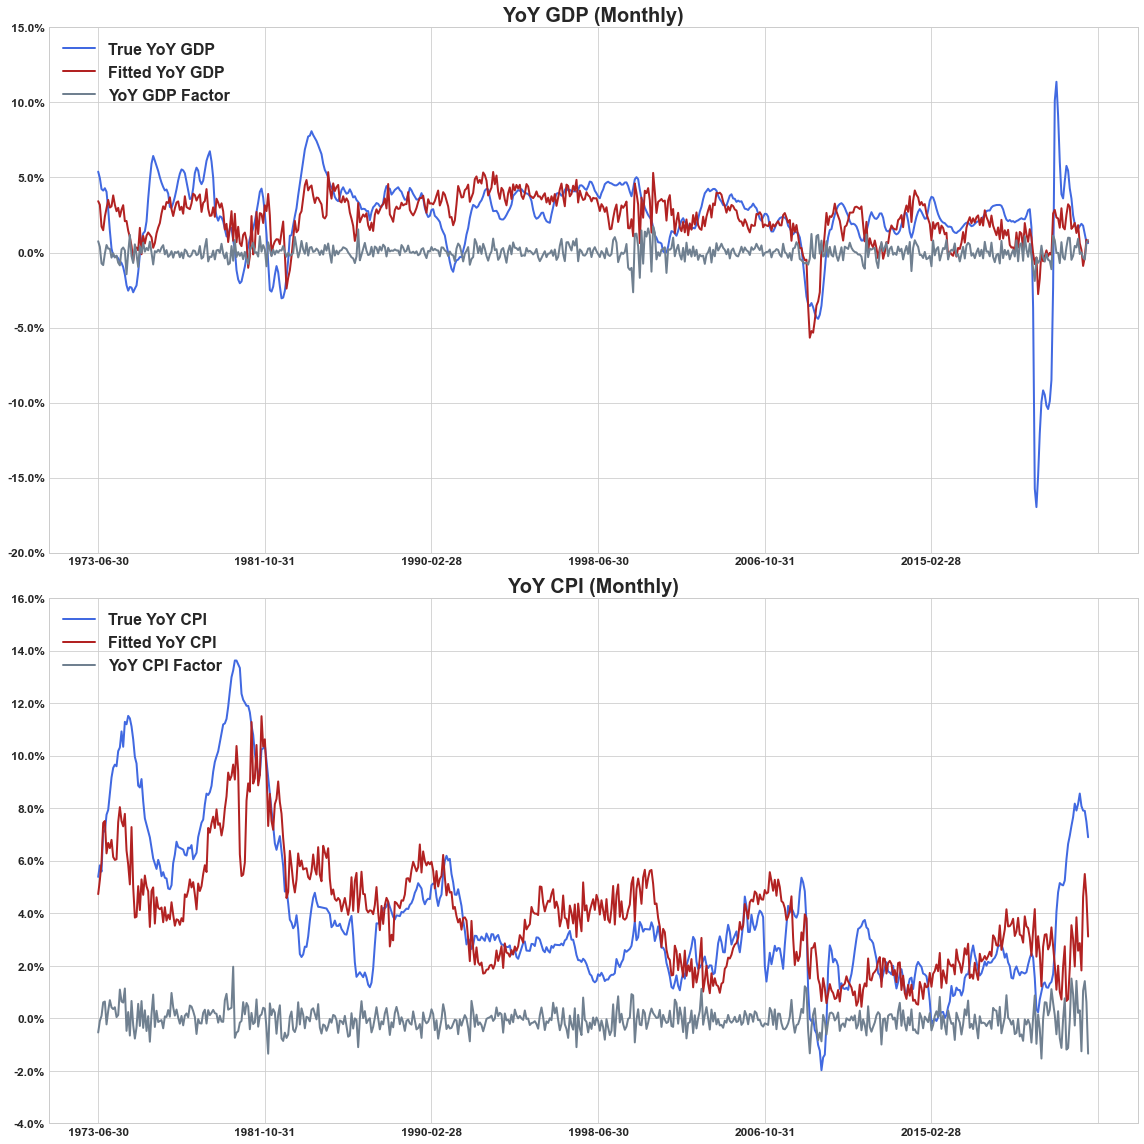

In [346]:
fig, ax = plt.subplots(2, 1, figsize=(16,16))

ax1 = monthly_data["true_gdp_yoy"].plot(ax=ax[0], legend=True, label="True YoY GDP", color='royalblue', linewidth=2)
ax1 = monthly_data["fitted_gdp_yoy"].plot(ax=ax[0], legend=True, label="Fitted YoY GDP", color='firebrick', linewidth=2)
ax1 = monthly_data["gdp_yoy_factor"].plot(ax=ax[0], legend=True, label="YoY GDP Factor", color='slategrey', linewidth=2)
ax1.set_title('YoY GDP (Monthly)', fontsize=20, weight='bold')
ax1.legend(loc=2, fontsize=16)
ax1.set_xlabel("")
ax1.set_yticks(ax1.get_yticks())
y_labels = ax1.get_yticks()
ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])


ax2 = monthly_data["true_cpi_yoy"].plot(ax=ax[1], legend=True, label="True YoY CPI", color='royalblue', linewidth=2)
ax2 = monthly_data["fitted_cpi_yoy"].plot(ax=ax[1], legend=True, label="Fitted YoY CPI", color='firebrick', linewidth=2)
ax2 = monthly_data["cpi_yoy_factor"].plot(ax=ax[1], legend=True, label="YoY CPI Factor", color='slategrey', linewidth=2)
ax2.set_title('YoY CPI (Monthly)', fontsize=20, weight='bold')
ax2.legend(loc=2, fontsize=16)
ax2.set_xlabel("")
ax2.set_yticks(ax2.get_yticks())
y_labels = ax2.get_yticks()
ax2.set_yticklabels([f'{x:0.1%}' for x in y_labels])

# fig.savefig('monthly_factors.jpg')
fig.tight_layout()
plt.show()

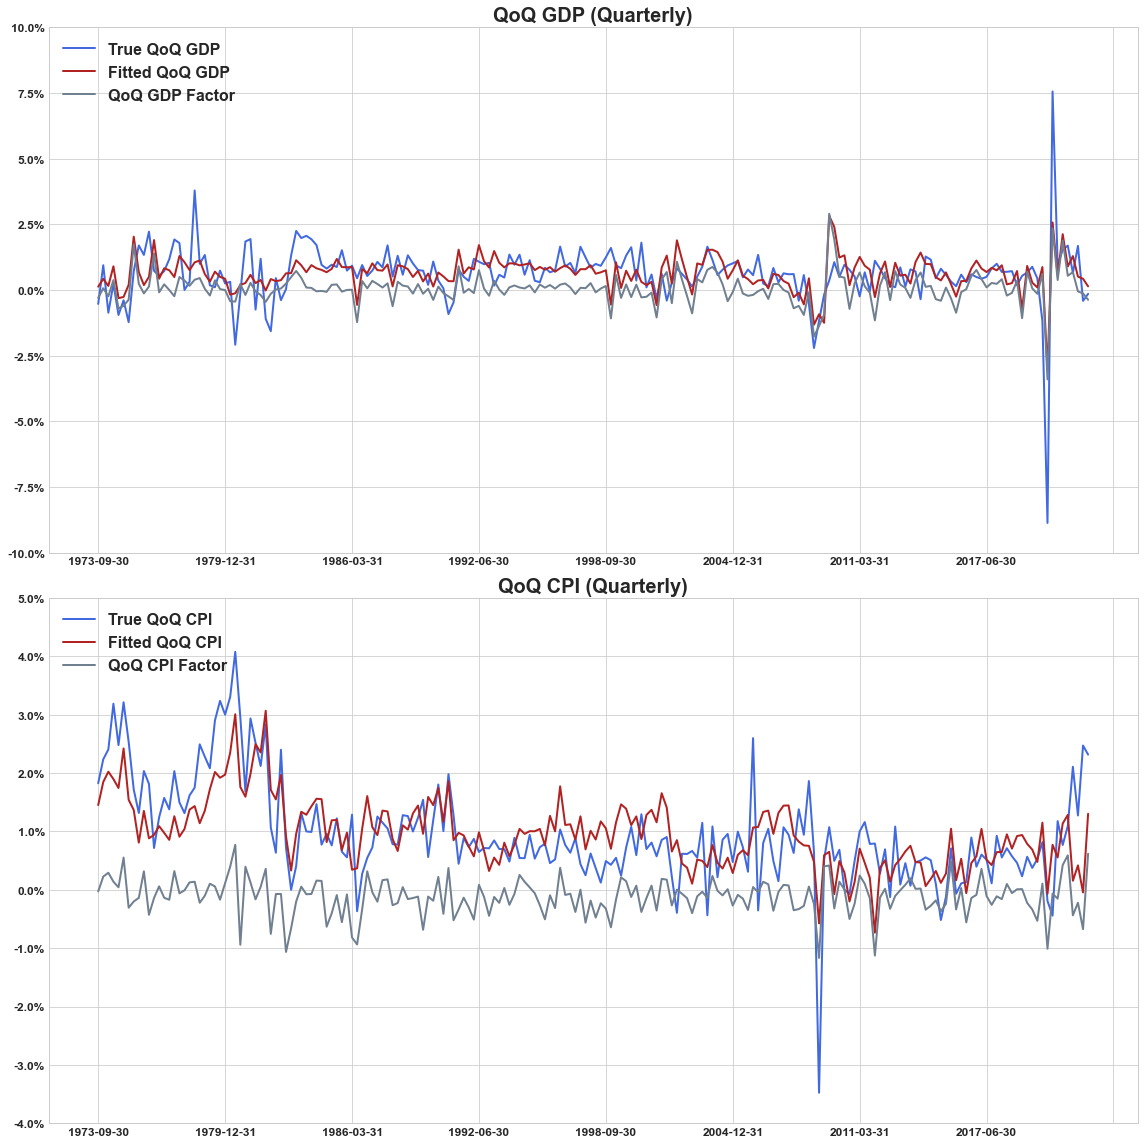

In [350]:
fig, ax = plt.subplots(2, 1, figsize=(16,16))

ax1 = quarterly_data["true_gdp_qoq"].plot(ax=ax[0], legend=True, label="True QoQ GDP", color='royalblue', linewidth=2)
ax1 = quarterly_data["fitted_gdp_qoq"].plot(ax=ax[0], legend=True, label="Fitted QoQ GDP", color='firebrick', linewidth=2)
ax1 = quarterly_data["gdp_qoq_factor"].plot(ax=ax[0], legend=True, label="QoQ GDP Factor", color='slategrey', linewidth=2)
ax1.set_title('QoQ GDP (Quarterly)', fontsize=20, weight='bold')
ax1.legend(loc=2, fontsize=16)
ax1.set_xlabel("")
ax1.set_yticks(ax1.get_yticks())
y_labels = ax1.get_yticks()
ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])


ax2 = quarterly_data["true_cpi_qoq"].plot(ax=ax[1], legend=True, label="True QoQ CPI", color='royalblue', linewidth=2)
ax2 = quarterly_data["fitted_cpi_qoq"].plot(ax=ax[1], legend=True, label="Fitted QoQ CPI", color='firebrick', linewidth=2)
ax2 = quarterly_data["cpi_qoq_factor"].plot(ax=ax[1], legend=True, label="QoQ CPI Factor", color='slategrey', linewidth=2)
ax2.set_title('QoQ CPI (Quarterly)', fontsize=20, weight='bold')
ax2.legend(loc=2, fontsize=16)
ax2.set_xlabel("")
ax2.set_yticks(ax2.get_yticks())
y_labels = ax2.get_yticks()
ax2.set_yticklabels([f'{x:0.1%}' for x in y_labels])

# fig.savefig('quarterly_factors.jpg')
fig.tight_layout()
plt.show()